# Predicting Vaccination Likelihood

# Business Understanding

In 2010, the seasonal flu virus was responsible for an estimated 290,000 hospitalizations and 37,000 deaths. The CDC recommends the seasonal flu vaccine as it has been shown to reduce the number of deaths, intensive care unit (ICU) admissions, ICU length of stay, and overall duration of hospitalization among hospitalized flu patients [1].

In light of their new vaccination initiative, the CDC has conducted surveys on random individuals throughout the country. In this notebook, we use the survey results to deliver a binary classifier model to the stakeholder (CDC) that determines if someone will take the Seasonal Flu vaccine based on responses to a phone survey. Predictions on future surveys can help assess public health risk by determining the percent of the population likely to get vaccinated.

# Data Understanding

The dataset was from the U.S. Department of Health and Human Services (DHHS) and consisted of phone surveys conducted in 2009 [2]. The survey contains demographic questions (age,sex,education etc.) along with opinion questions (vaccine effectiveness, flu risk, etc.) The target variable was whether or not the vaccine was taken. 47% of respondents to the survey had taken the 2009 seasonal flu vaccine.

# Data Preparation

Let's start by importing modules necessary for analysis and reading in the data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import graphviz

import code.preprocessing as pp
import code.visualization as viz

In [2]:
df_var = pd.read_csv('data/training_set_features.csv')
df_tar = pd.read_csv('data/training_set_labels.csv')['seasonal_vaccine']

The dataset includes questions related to the 2009 H1N1 flu and vaccine as well. These input variables have been dropped from the dataset due to relevance to the business problem (seasonal flu vaccine).

In [3]:
df_var = pp.df_dropped(df_var)

Features dropped from original set: ['respondent_id', 'h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'doctor_recc_h1n1', 'hhs_geo_region']


 

In addition, four input variables (health_insurance , income_poverty, employment_industry and employment_occupation) had high amounts of missing data (>10% missing), so these columns are also dropped. 

In [4]:
df_var = pp.df_dropped_nan(df_var)

Features dropped from set: ['health_insurance', 'income_poverty', 'employment_industry', 'employment_occupation']


Next, let's perform a train-test split. 

In [5]:
X_train,X_test,y_train,y_test = train_test_split(df_var,df_tar,random_state=42)
X_train = X_train.copy(deep=True)

## Preprocessing

In the below cell, we are using pipelines and transformers to impute, encode and scale the training set. 

In [6]:
impute_pipe, columns = pp.pipe_impute()

imputed_array = impute_pipe.fit_transform(X_train)

X_train_pipe_impute = pd.DataFrame(imputed_array, columns=columns)

encode_pipe, col_trans, impute_drop, ohe_cols, oe_cols = pp.pipe_encode(X_train_pipe_impute)

encoder = col_trans.named_transformers_['ohe']
category_labels = encoder.get_feature_names(ohe_cols)

oe_ohe_labels = oe_cols + list(category_labels)

X_train_pipe_impute_trans = encode_pipe.fit_transform(X_train_pipe_impute)

X_train_pipe_processed = pd.DataFrame(X_train_pipe_impute_trans, columns=oe_ohe_labels+list(X_train_pipe_impute.drop(impute_drop, axis=1).columns))

# Sex - 0=Female | 1=Male
# Marital Status - 0=Married | 1=Not Married
# Rent or Own - 0=Own | 1=Rent


In the below cell, we are using the pipelines and transformers created above to impute, encode and scale the test set. 

In [7]:
imputed_X_test = impute_pipe.transform(X_test)
X_test_pipe_impute = pd.DataFrame(imputed_X_test, columns=columns)
X_test_pipe_impute_trans = encode_pipe.transform(X_test_pipe_impute)

X_test_pipe_processed = pd.DataFrame(X_test_pipe_impute_trans, columns=oe_ohe_labels+list(X_train_pipe_impute.drop(impute_drop, axis=1).columns))


# Modeling

## Baseline Model 

The team decided to use a dummy model that always predicts the most frequent class of target variable which is the individual did not get the vaccine (0) as a baseline model.

In [8]:
dc = DummyClassifier(strategy='most_frequent',random_state=42)
dc.fit(X_train_pipe_processed,y_train)
cross_val_score(dc,X_train_pipe_processed,y_train,cv=5,scoring='roc_auc').mean()

0.5

The team decided to use Receiver Operating Characteristic (ROC) area under curve (AUC) as the performance metric for the models. This is because ROC AUC value gives equal importance to how well models do on false positives and false negatives. For this business problem, false positives (predicting someone is vaccinated when they are not) is not desired as it is optimal to identify as many non-vaccinated people as possible. False negatives (predicting someone is not vaccinated when they are) are not desired as well since the stakeholder would not want to spend resources on people that are already vaccinated.

The average cross validation ROC AUC is 0.5 (50%). Let's also look at the test ROC AUC.

In [9]:
roc_auc_score(y_test,dc.predict(X_test_pipe_processed))

0.5

The test ROC AUC is also 50%. Let's see what the ROC curve looks like.

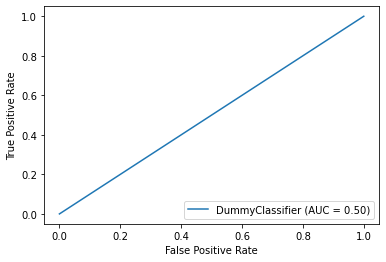

In [10]:
plot_roc_curve(dc,X_test_pipe_processed,y_test);

This is a binary classification problem, so this baseline model is as good as randomly guessing whether someone got vaccinated. Let's look at some classification methods to see if we can obtain a better model.

## One Feature Logistic Regression Model

The team decided to select a logistic regression utilizing a single feature as the first classification model. The team chose logistic regression as it is a simple classification algorithm and the model will have only one feature as multicolinearity issues were encountered that will be explained shortly. 

Let's start by using grid search to find the optimal hyperparameters to use in the logistic regression.

In [11]:
logreg_l1 = LogisticRegression()

param_grid = {
    'C': np.linspace(1e-5,1,50),
    'solver': ['liblinear','saga'],
    'penalty': ['l1']
}

pp.grid_search(param_grid, logreg_l1, X_train_pipe_processed, y_train, cv=3)

{'C': 0.08164183673469387, 'penalty': 'l1', 'solver': 'saga'}

Next, let's perform Recursive Feature Elimination (RFE) in order to find the single best feature to use, 

In [12]:
lr_model = LogisticRegression(penalty='l1',solver='saga',C = 0.08164183673469387)
lr_cv_rfe, lr_keep_lists = pp.rfe(X_train_pipe_processed, y_train, n_features=1, model=lr_model)

Features selected: ['opinion_seas_vacc_effective_5.0']


Now that we have the best feature and the best hyperparameters, we can generate the model and analyze it's performance. 

In [13]:
logreg_final = LogisticRegression(penalty='l1',solver='saga',C = 0.08164183673469387)
logreg_final.fit(X_train_pipe_processed[lr_keep_lists[0]],y_train)
cross_val_score(lr_model,X_train_pipe_processed[lr_keep_lists[0]],y_train,cv=5,scoring='roc_auc').mean()

0.6797286000175904

The average cross validation ROC AUC is 0.68 (68%). Let's also look at the test ROC AUC.

In [14]:
roc_auc_score(y_test,logreg_final.predict_proba(X_test_pipe_processed[lr_keep_lists[0]])[:,1])

0.6785140829544462

The test ROC AUC is also 68%. The train and test ROC AUC are equally low, so this model is underfit. 

Let's also visualize the ROC curve.

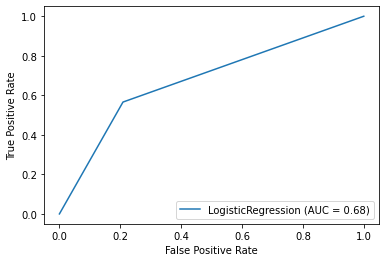

In [15]:
plot_roc_curve(logreg_final,X_test_pipe_processed[lr_keep_lists[0]],y_test);

Finally, let's look at the confusion matrix to see how the model did on the training set.

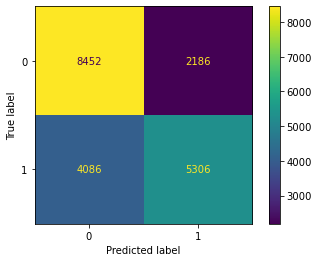

In [16]:
plot_confusion_matrix(logreg_final,X_train_pipe_processed[lr_keep_lists[0]],y_train);

This model shows significant improvement compared to the baseline model in predicting both the training and test sets (ROC AUC improved from 50% to 68%). So, the team attempted to continue improving this model by adding more features, however, high multicollinearity was observed between many variables that were significant predictors of the target variable. Therefore, the team decided to use a decision tree as a step-up model and leave the one-feature logistic regression as is. More details on the multicollinearity analysis can be found in the appendix folder of this repository.

## Step-up Model: Decision Tree

The team decided to use a decision tree as a step-up model as it is immune to multicollinearity, easy to visualize and easy to interpret. To keep the model inferential, only top five features will be used.

Let's start by using grid search to find the optimal hyperparameters to use in the decision tree.

In [17]:
dt = DecisionTreeClassifier()

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,6,7,8,9,10],
    'min_samples_split': [30,35,40,45],
    'random_state': [0,10,20]
}
pp.grid_search(param_grid_dt, dt, X_train_pipe_processed, y_train, cv=5)

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_split': 35,
 'random_state': 0}

In order to find the top five features to use, let's perform Recursive Feature Elimination (RFE) for Decision Tree in the cell below.

In [18]:
# Recursive Feature Elimination for Decision Tree
dt_model = DecisionTreeClassifier(criterion = 'gini',max_depth = 8,min_samples_split = 35,random_state = 0)
dt_cv_rfe, dt_keep_lists = pp.rfe(X_train_pipe_processed, y_train, n_features=5, model=dt_model)

Features selected: ['opinion_seas_vacc_effective_5.0', 'opinion_seas_risk_4.0', 'opinion_seas_risk_5.0', 'age_group_65+ Years', 'doctor_recc_seasonal']


Next, let's plot the relationship between number of features and average Cross Validation ROC AUC

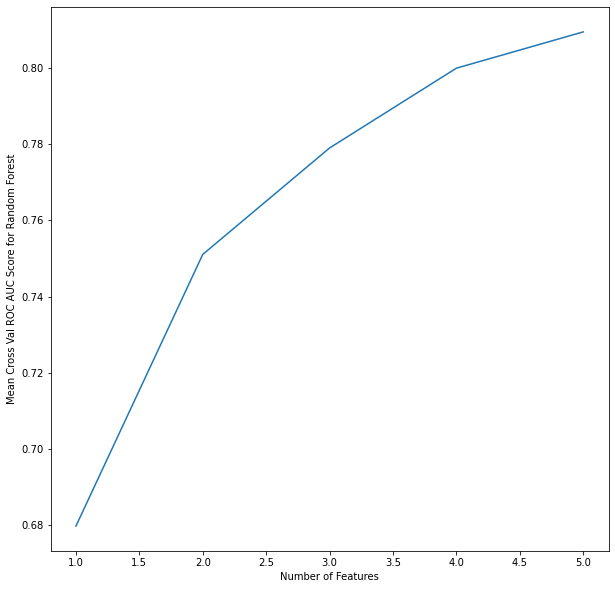

In [19]:
viz.roc_score_plot(5, dt_cv_rfe)

It appears that five features yields the maximum ROC AUC value, therefore we will use five features.

Now that we have the top five features and the best hyperparameters, we can generate the model and analyze it's performance.

In [20]:
dt_final = DecisionTreeClassifier(criterion = 'gini',max_depth = 8,min_samples_split = 35,random_state = 0)
dt_final.fit(X_train_pipe_processed[dt_keep_lists[4]],y_train)
cross_val_score(dt_final,X_train_pipe_processed[dt_keep_lists[4]],y_train,cv=5,scoring='roc_auc').mean()

0.8098404021135082

The average cross validation ROC AUC is 0.81 (81%) which is considerably higher than the average cross validation ROC AUC of the one feature logistic regression model (68%).

Let's also look at the test ROC AUC.

In [21]:
roc_auc_score(y_test,dt_final.predict_proba(X_test_pipe_processed[dt_keep_lists[4]])[:,1])

0.8149016093125664

The test ROC AUC is 81.5%. This model has a higher test ROC AUC than the one feature logistic regression model (68%).  

Let's look at the confusion matrix to see how the model did on the training set.

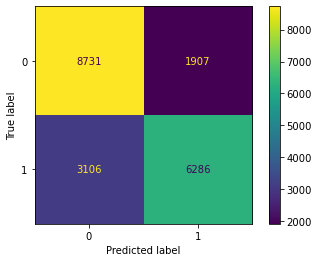

In [22]:
plot_confusion_matrix(dt_final,X_train_pipe_processed[dt_keep_lists[4]],y_train);

Let's now plot the ROC curve to visualize the area under the curve (AUC).

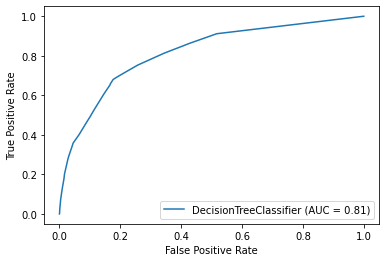

In [23]:
plot_roc_curve(dt_final,X_test_pipe_processed[dt_keep_lists[4]],y_test);

Finally, let's visualize the tree generated by the model.

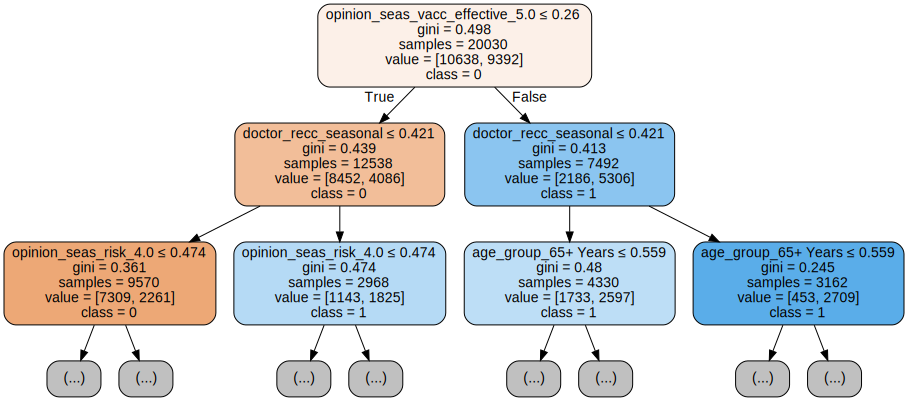

In [24]:
viz.tree_viz(dt_final, dt_keep_lists, y_train)

The tree shows the most important features for someone to get the seasonal flu vaccine:

* Scoring a 5/5 for vaccine efficacy opinion
* Being 65+ or older
* Doctor recommending the vaccine

## Random Forest  - Predictive Model

The team decided to use a random forest as the final model as it will improve upon the decision tree model. Random forests are ensemble models that can increase performance and decrease model overfitting.

Let's start by using grid search to find the optimal hyperparameters to use in the random forest.

In [25]:
RF = RandomForestClassifier()
param_grid_RF = {
      'n_estimators' : [10,100],
      'criterion' : ['gini', 'entropy'],
      'max_depth' : [50,100,500],
      'min_samples_split': [10,20,30],
      'random_state': [0,100,200]
}
pp.grid_search(param_grid_RF, RF, X_train_pipe_processed, y_train, cv=5)

{'criterion': 'entropy',
 'max_depth': 50,
 'min_samples_split': 30,
 'n_estimators': 100,
 'random_state': 0}

In order to find the top features to use, we will perform Recursive Feature Elimination (RFE) for Random Forest in the cell below.

In [26]:
RF_model = RandomForestClassifier(criterion = 'entropy', max_depth = 50, min_samples_split = 30, n_estimators= 100,
                                    random_state = 0)
RF_cv_rfe, RF_keep_lists = pp.rfe(X_train_pipe_processed, y_train, n_features=20, model=RF_model)

Features selected: ['marital_status', 'rent_or_own', 'opinion_seas_vacc_effective_2.0', 'opinion_seas_vacc_effective_4.0', 'opinion_seas_vacc_effective_5.0', 'opinion_seas_risk_2.0', 'opinion_seas_risk_4.0', 'opinion_seas_risk_5.0', 'opinion_seas_sick_from_vacc_5.0', 'age_group_55 - 64 Years', 'age_group_65+ Years', 'education_College Graduate', 'race_White', 'employment_status_Not in Labor Force', 'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 'health_worker', 'household_adults', 'household_children']


Let's plot the relationship between number of features and mean Cross Validation ROC AUC.

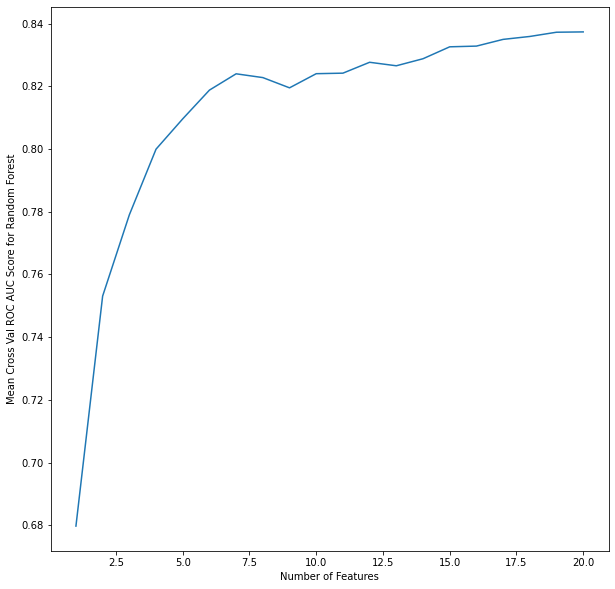

In [27]:
viz.roc_score_plot(20, RF_cv_rfe)

It appears that 20 features yields the maximum ROC AUC value.

Now that we have the top features and the best hyperparameters, we can generate the model and analyze it's performance.

In [28]:
RF_final = RandomForestClassifier(criterion = 'entropy', max_depth = 50, min_samples_split = 30,n_estimators= 100,
                                  random_state = 0)
RF_final.fit(X_train_pipe_processed[RF_keep_lists[19]],y_train)
cross_val_score(RF_final,X_train_pipe_processed[RF_keep_lists[19]],y_train,cv=5,scoring='roc_auc').mean()

0.8378119471925253

The average cross validation ROC AUC is 0.838 (83.8%), which is higher than the average cross validation ROC AUC of the Decision Tree (81%).

Let's also look at the test ROC AUC.

In [29]:
roc_auc_score(y_test,RF_final.predict_proba(X_test_pipe_processed[RF_keep_lists[19]])[:,1])

0.8436681098711534

The test ROC AUC is 84.4%. This model has a higher test ROC AUC than the decision tree model (81.5%).

Let's look at the confusion matrix to see how the model did on the training set.

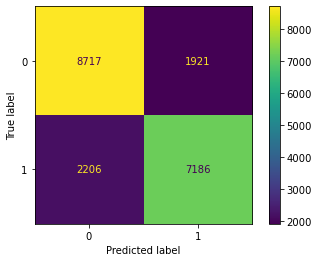

In [30]:
plot_confusion_matrix(RF_final,X_train_pipe_processed[RF_keep_lists[19]],y_train);

Let's now plot the ROC curve to visualize the area under the curve (AUC).

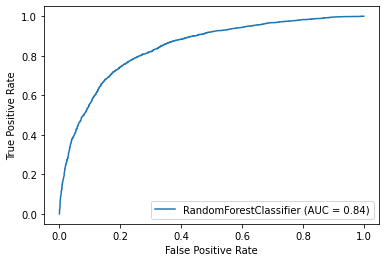

In [31]:
plot_roc_curve(RF_final,X_test_pipe_processed[RF_keep_lists[19]],y_test);

The random forest yields the highest train and test ROC AUC value out of all models. This means that it is the best at  minimizing the false positives (predicting someone is vaccinated when they are not) and false negatives (predicting someone is not vaccinated when they are).

# Conclusion

The below graph shows the improvement on the performance metric of ROC AUC of each model. The final model (Random Forest) showed an increase of .17 over the logistic regression model and .34 over the baseline model (majority class).

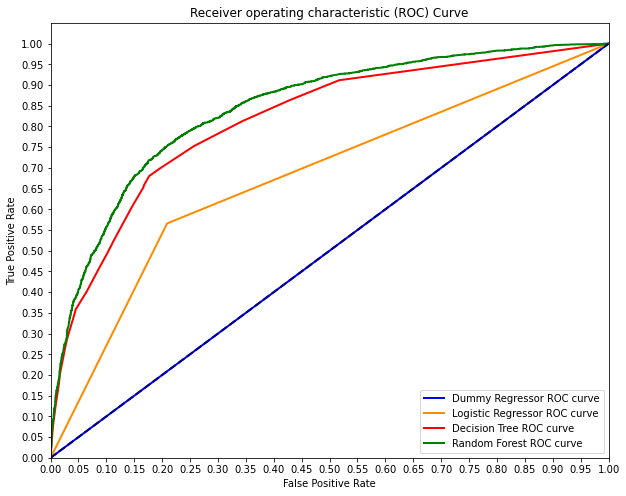

In [32]:
viz.all_roc_curves(X_test_pipe_processed, y_test, dc, logreg_final, dt_final, RF_final, lr_keep_lists, dt_keep_lists, RF_keep_lists)

From the initial tree splits of the decision tree model, the following recommendations can be made to improve the phone survey and increase the likelihood of someone taking the vaccine.

Recommendations:

1) Shorten survey to important opinion features to improve survey response.

    - Doctor Recommended Vaccine?

    - Age Group
    
    - Opinion on Vaccine Efficacy
    
2) Education on vaccination efficacy will help improve peoples willingness to receive a seasonal flu vaccine.

3) Encourage healthcare professionals to recommend the seasonal flu vaccine.

# Future Research

* Look to improve completion rate of survey so the dropped columns listed in data cleaning section can be utilized.
* Gather more demographic data like location to make more inferential recommendations

# Citations

[1] : https://www.cdc.gov/flu/prevent/flushot.htm

[2] : https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/